### Data preprocessing of Find it Fix It requests to the City of Seattle (from a FOI request)

In [50]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import datetime as dt
import string

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("poster")
sns.set_style("dark")
sns.set_style("ticks")
#import yellowbrick as yb

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

In [51]:
#path for FIFI FOI request
path = 'C:/Users/Schindler/Documents/ProgrammingFun/FIFI/FIFI_data_through_5-12-19.xlsx'

In [56]:
#original file has multiple sheets (for different FIFI types)
whole_file = pd.ExcelFile(path)

print(whole_file.sheet_names)

combined_data = pd.DataFrame()
for sheet_name in whole_file.sheet_names:
    sheet_data = pd.DataFrame(data = pd.read_excel(whole_file, sheetname=sheet_name))
    print(sheet_name)
    print(sheet_data.columns.values)
    sheet_data['FIFI_category'] = [sheet_name]*sheet_data.shape[0]
    combined_data = pd.concat([combined_data, sheet_data], sort=False)

combined_data.reset_index(drop=True, inplace=True)
print(combined_data.shape)
combined_data.head(1)

['Abandoned Vehicle', 'Clogged Storm Drain', 'Community Walk', 'Dead Animal', 'Graffiti Report', 'Litter-Illegal Dumping-Needles', 'Overgrown Vegetation', 'Parking Enforcement', 'Pothole', 'Sign and Signal Maintenance', 'Streetlight Report', 'Other Inquiry']
Abandoned Vehicle
['Service Request Number' 'Created Date' 'Location' 'Location Details'
 'Description' 'License Number' 'State' 'Vehicle Make' 'Vehicle Color'
 'Length of Time Parked' 'Photo']
Clogged Storm Drain
['Service Request Number' 'Created Date' 'Location' 'Location Details'
 'Description' 'Location Details.1' 'Causing property damage?' 'Photo']
Community Walk
['Service Request Number' 'Created Date' 'Location' 'Location Details'
 'Description' 'Current Issue' 'Location Details.1' 'Photo']
Dead Animal
['Service Request Number' 'Created Date' 'Location' 'Location Details'
 'Description' 'Type of animal' 'On private property?' 'Photo']
Graffiti Report
['Service Request Number' 'Created Date' 'Location' 'Location Details'
 'D

,Service Request Number,Created Date,Location,Location Details,Description,License Number,State,Vehicle Make,Vehicle Color,Length of Time Parked,Photo,FIFI_category,Location Details.1,Causing property damage?,Current Issue,Type of animal,On private property?,What is the Graffiti on?,Location and Description,"Obscene, racial, or hateful?",Cross street or intersection?,Where?,Type of item?,Where is the vegetation growing,Vegetation Safety Issue,Parking Violation Concerning,License Plate Number,Location details,7 digit number on pole,Issue
0,13-00036779,2013-05-09 20:32:33,"5208 BEACON AVE S, SEATTLE, WA","5200 Beacon Ave S Seattle, WA 98108; XY: 12775...",Ford light blue,AHZ9829,NaN,Ford,Blue,Over 3 Days,NaN,Abandoned Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
#update FIFI_cat names

combined_data.columns = combined_data.columns.str.replace(' ', '_')

combined_data.rename(columns={'Length_of_Time_Parked': 'Time_parked', 
                       'Causing_property_damage?': 'Property_damage?',
                       'What_is_the_Graffiti_on?': 'Graffiti_location', 
                       'Obscene,_racial,_or_hateful?': 'Obscene/Racial/Hateful?', 
                       'Cross_street_or_intersection?': 'Street/Intersection',
                       'Where_is_the_vegetation_growing': 'Veg_location'}, inplace=True)

combined_data.replace({'Over 1 month': 'Over 1 Month',
                       'Over 3 months': 'Over 3 Months',
                       'Over 3 days': 'Over 3 Days',
                       'Over 1 week': 'Over 1 Week',
                       'Litter-Illegal Dumping-Needles': 'Needles/Dumping', 
                       'Other Inquiry': 'Other',
                       'Clogged Storm Drain': 'Clogged_Drain',
                       'Overgrown Vegetation': 'Vegetation',
                       'Abandoned Vehicle': 'Abnd_Vehicle',
                       'Parking Enforcement': 'Parking',
                       'Graffiti Report': 'Grafitti',
                       'Sign and Signal Maintenance': 'Sign/Signal',
                       'Streetlight Report': 'Streetlight'}, inplace=True)

combined_data['Vehicle_Make'] = combined_data['Vehicle_Make'].str.capitalize()

Combined data shape:  (248885, 30) 

Combined data shape:  (248884, 36) 



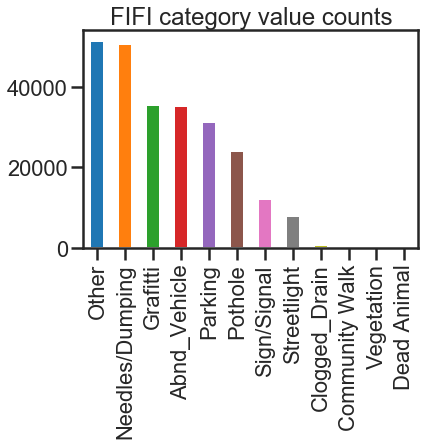

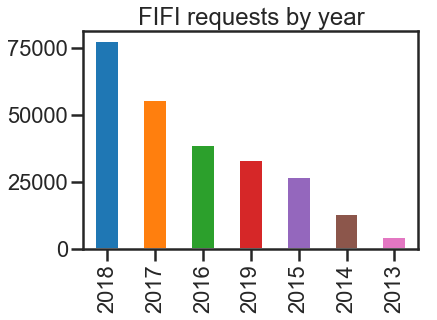

,Service_Request_Number,Created_Date,Location,Location_Details,Description,License_Number,State,Vehicle_Make,Vehicle_Color,Time_parked,Photo,FIFI_category,Location_Details.1,Property_damage?,Current_Issue,Type_of_animal,On_private_property?,Graffiti_location,Location_and_Description,Obscene/Racial/Hateful?,Street/Intersection,Where?,Type_of_item?,Veg_location,Vegetation_Safety_Issue,Parking_Violation_Concerning,License_Plate_Number,Location_details,7_digit_number_on_pole,Issue,date,year,month,day,day_of_week,hour,zip
0,13-00036779,2013-05-09 20:32:33,"5208 BEACON AVE S, SEATTLE, WA","5200 Beacon Ave S Seattle, WA 98108; XY: 12775...",Ford light blue,AHZ9829,NaN,Ford,Blue,Over 3 Days,NaN,Abnd_Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-05-09,2013,5,9,Thursday,20,WA


In [68]:
#clean and preprocess data
print('Combined data shape: ', combined_data.shape, '\n')

#create date column and bins
combined_data['date'] = combined_data['Created_Date'].dt.date
combined_data['year'] = combined_data['Created_Date'].dt.year
combined_data['month'] = combined_data['Created_Date'].dt.month
combined_data['day'] = combined_data['Created_Date'].dt.day
combined_data['day_of_week'] = combined_data['Created_Date'].dt.day_name()
combined_data['day_of_week'] = pd.Categorical(combined_data['day_of_week'], categories=
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],
    ordered=True)
combined_data['hour'] = combined_data['Created_Date'].dt.hour

#create study date bins
#combined_data['date_bin'] = pd.cut(combined_data['date'], 36)

#drop any rows where location data is not filled in
#combined_data.dropna(subset='Location', axis=0, inplace=True)
combined_data = combined_data[~combined_data['Location'].isnull()]
print('Combined data shape: ', combined_data.shape, '\n')

#create new column with zip code
combined_data['zip'] = combined_data.apply(lambda row: row['Location'].split()[-1], axis=1)   

#viz FIFI requests by category
combined_data['FIFI_category'].value_counts().plot(kind='bar')
plt.title('FIFI category value counts')
plt.show()
print('\n')

#viz FIFI requests by year
combined_data['year'].value_counts().plot(kind='bar')
plt.title('FIFI requests by year')
plt.show()

combined_data.head(1)

In [69]:
#create dictionary of zips and corresponding neighborhoods, add neighborhood as new column

zip_neighborhood_dic = {'98028': 'Kenmore',  
                        '98031': 'Kent',
                        '98057': 'Renton',
                        '98101': 'Dt/FirstH', 
                        '98102': 'Cap_Hill', 
                        '98103': 'GnWd/Frmt/GnLk', 
                        '98104': 'PioneerS/FirstH',
                        '98105': 'Udist/LarHur', 
                        '98106': 'Delridge',
                        '98107': 'Ballard', 
                        '98108': 'South_Park',
                        '98109': 'Westlake',
                        '98112': 'Madison_Park',
                        '98115': 'Wedgewood',
                        '98116': 'WestS_Alki', 
                        '98117': 'Ballard',
                        '98118': 'ColCity/SewardP', 
                        '98119': 'Queen_Anne',
                        '98121': 'Belltown',
                        '98122': 'Leschi',
                        '98125': 'Northgate', 
                        '98126': 'Delridge',
                        '98133': 'Bitterlake',
                        '98134': 'Harbor_Island',
                        '98136': 'Fauntleroy',
                        '98144': 'MtBaker', 
                        '98146': 'Arbor_Heights',
                        '98148': 'Sunnydale',
                        '98155': 'North_City',
                        '98164': 'DT_library',
                        '98166': 'Gregory_Heights',
                        '98168': 'Burien',
                        '98177': 'LoyalH/Highlands',
                        '98178': 'Lakeridge',
                        '98188': 'SeaTac',
                        '98195': 'UW_campus',
                        '98199': 'Magnolia',
                        '98370': 'unknown',
                        'WA': 'WA'}

zip_list = list(zip_neighborhood_dic.keys())

print('Combined data shape before zip filtering: ', combined_data.shape, '\n')
zip_filtered = combined_data[combined_data['zip'].isin(zip_list)]
print('Combined data shape after zip filtering: ', zip_filtered.shape, '\n')

#add neighborhood as column according to zip
zip_filtered['neighborhood'] = zip_filtered.apply(lambda row: zip_neighborhood_dic[row['zip']], axis=1)

zip_filtered.head(1)

Combined data shape before zip filtering:  (248884, 37) 

Combined data shape after zip filtering:  (248815, 37) 



,Service_Request_Number,Created_Date,Location,Location_Details,Description,License_Number,State,Vehicle_Make,Vehicle_Color,Time_parked,Photo,FIFI_category,Location_Details.1,Property_damage?,Current_Issue,Type_of_animal,On_private_property?,Graffiti_location,Location_and_Description,Obscene/Racial/Hateful?,Street/Intersection,Where?,Type_of_item?,Veg_location,Vegetation_Safety_Issue,Parking_Violation_Concerning,License_Plate_Number,Location_details,7_digit_number_on_pole,Issue,date,year,month,day,day_of_week,hour,zip,neighborhood
0,13-00036779,2013-05-09 20:32:33,"5208 BEACON AVE S, SEATTLE, WA","5200 Beacon Ave S Seattle, WA 98108; XY: 12775...",Ford light blue,AHZ9829,NaN,Ford,Blue,Over 3 Days,NaN,Abnd_Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-05-09,2013,5,9,Thursday,20,WA,WA


In [70]:
zip_filtered.to_pickle('zip_filtered_data.pkl')